In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
from PIL import Image
import torchvision
torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.8.1+cpu


In [3]:
class_names = ['normal', 'viral_pneumonia', 'covid', 'lung_opacity']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)


class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names =  ['normal', 'viral_pneumonia', 'covid', 'lung_opacity']

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

        self.image_dirs = image_dirs
        self.transform = transform


    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])


    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)


train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/normal',
    'viral_pneumonia': 'COVID-19_Radiography_Dataset/viral_pneumonia',
    'covid': 'COVID-19_Radiography_Dataset/covid',
    'lung_opacity': 'COVID-19_Radiography_Dataset/lung_opacity'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)


test_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral_pneumonia': 'COVID-19_Radiography_Dataset/test/viral_pneumonia',
    'covid': 'COVID-19_Radiography_Dataset/test/covid',
    'lung_opacity': 'COVID-19_Radiography_Dataset/test/lung_opacity'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)


batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Found 10162 normal examples
Found 1315 viral_pneumonia examples
Found 3586 covid examples
Found 5982 lung_opacity examples
Found 30 normal examples
Found 30 viral_pneumonia examples
Found 30 covid examples
Found 30 lung_opacity examples


c:\users\desktop\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:589: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


tensor([1, 3, 3, 2, 1, 2])


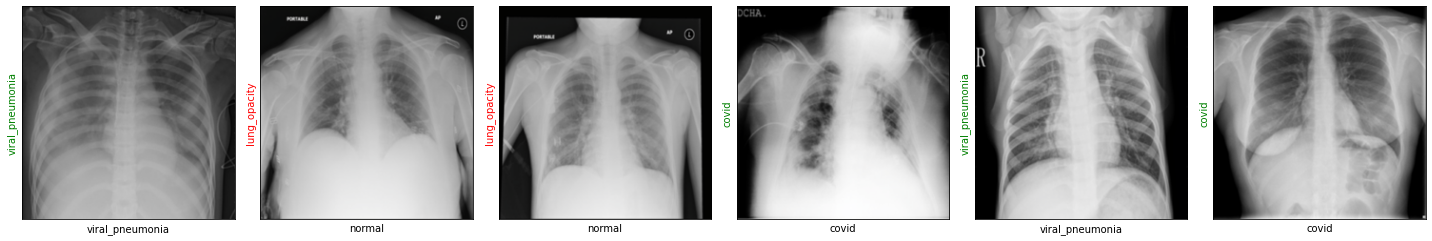

In [5]:
model = torch.load('covid_model.pt')
def show_preds():
    model.eval()
    images, labels = next(iter(dl_test))
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    print(preds)
    show_images(images, labels, preds)
    class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(20,10))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

show_preds()